In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
info_data_path = "../data/raw_data/data.info"
with open(info_data_path, 'r') as f:
    info = f.read().splitlines()

info_list = [info[i].split(",") for i in range(len(info))]
info_df = pd.DataFrame(info_list[1:]) 
info_df.columns = info_list[0]

In [3]:
info_df["transcript_position"] = info_df["transcript_position"].astype(str).astype(int)

In [6]:
hepG2_rep5_run2 = pd.read_csv("../data/aws_predictions/hepG2_rep5_run2__prediction.csv")
hepG2_rep6_run1 = pd.read_csv("../data/aws_predictions/hepG2_rep6_run1_prediction.csv")

In [7]:
hepG2_rep5_run2["label"] = hepG2_rep5_run2.score.map(lambda x:1 if x>=0.35 else 0)
hepG2_rep6_run1["label"] = hepG2_rep6_run1.score.map(lambda x:1 if x>=0.35 else 0)

In [10]:
merge1 = hepG2_rep5_run2.merge(hepG2_rep6_run1, on = ['transcript','position'],how='inner')

In [12]:
merge1['new'] = np.where((merge1['label_x'] == merge1['label_y']), True, False)

In [14]:
merged_d0 = merge1.merge(info_df, how = "left", left_on = ["transcript", "position"], right_on = ["transcript_id", "transcript_position"])
merged_d0 = merged_d0.drop(["transcript_id", "transcript_position"], axis = 1)
merged_d0.label= merged_d0.label.astype(int)

In [15]:
merged_d0['x_actual'] = np.where((merged_d0['label_x'] == merged_d0['label']), True, False)
merged_d0['y_actual'] = np.where((merged_d0['label_y'] == merged_d0['label']), True, False)

In [16]:
merged_d0['mean_scores'] = merged_d0[['score_x', 'score_y']].mean(axis=1)
merged_d0["pred_mean"] = merged_d0.mean_scores.map(lambda x:1 if x>=0.35 else 0)

In [17]:
merged_d0['mean_actual'] = np.where((merged_d0['pred_mean'] == merged_d0['label']), True, False)

In [18]:
ind = ind = ["rep5_run1", "rep6_run1", "mean"]
rep5_count = list(merged_d0["x_actual"].value_counts())
rep6_count = list(merged_d0["y_actual"].value_counts())
mean_count = list(merged_d0["mean_actual"].value_counts())

In [19]:
df = pd.DataFrame([rep5_count[0], rep6_count[0], mean_count[0]], columns = ["True"], index = ind)
df["False"] = [rep5_count[1], rep6_count[1], mean_count[1]]
df = df.transpose()

Text(0.5, 1.0, 'HepG2 Cancer Cell Line')

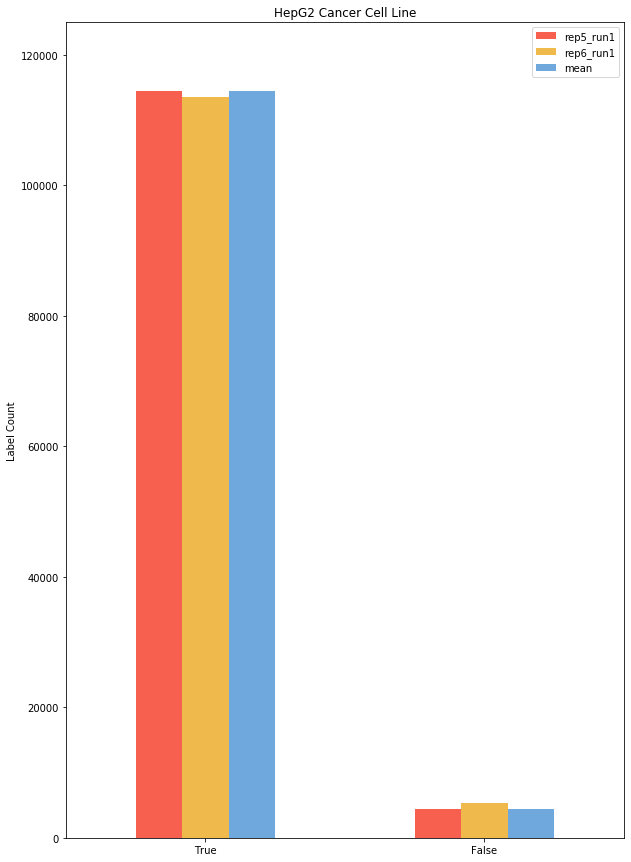

In [20]:
from turtle import width

colour_scheme = {"rep5_run1": "#f75f4f", "rep6_run1": "#efb94b",  "mean": "#6fa8dc"}
df.plot(kind = "bar", figsize = (10, 15), color = colour_scheme)

plt.ylabel("Label Count")
plt.ylim([0, 125000])
plt.gca().xaxis.set_tick_params(rotation = 0)
plt.title("HepG2 Cancer Cell Line")

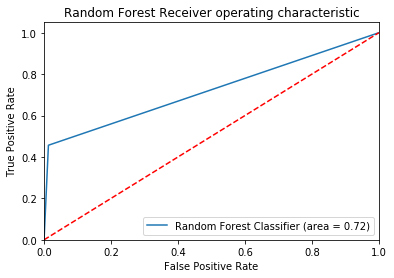

In [21]:
## define roc metrics
y_pred = merged_d0.pred_mean
y_test = merged_d0.label.astype(int)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

## plot roc curve
plt.figure()
plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()